## Learn to use tensorflow object detection API
- [official repo](https://github.com/tensorflow/models/tree/master/research/object_detection)
- [TensorMouse](https://github.com/tadejmagajna/TensorMouse)

In [1]:
import cv2
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import patches
from IPython import display

%matplotlib notebook


# %matplotlib inline

## load graph and make session

In [2]:
## load the frozen graph

def load_model(model_path):
    graph = tf.Graph()
    with graph.as_default():
        graph_def = tf.GraphDef()
        model_file = tf.gfile.GFile(model_path, "rb")
        graph_def.ParseFromString(model_file.read())
        tf.import_graph_def(graph_def, name="object_detection_api")
    return graph

model_path = "../../models/object_detection/ssd_mobilenet_v1_coco_11_06_2017/frozen_inference_graph.pb"
model_graph = load_model(model_path)

In [3]:
## load label names - taking a shortcut
import re
def load_labels(label_path):
    id2label = {}
    
    with open(label_path, "r") as f:
        items = re.findall(r"item\s*\{[^}]*\}", f.read(), re.MULTILINE)
        for item in items:
            id = int(re.findall(r"id: (\d+)", item)[0])
            label = re.findall(r'display_name: "([\w\s]+)"', item)[0]
            id2label[id] = label
    return id2label

label_path = "../../models/object_detection/mscoco_label_map.pbtxt"
id2label = load_labels(label_path)

In [4]:
model_sess = tf.Session(graph = model_graph)

In [5]:
def detect_objects(sess, id2label, img, prob_thr):
    
    ## object detection

    image = model_graph.get_tensor_by_name("object_detection_api/image_tensor:0")
    boxes = model_graph.get_tensor_by_name("object_detection_api/detection_boxes:0")
    scores = model_graph.get_tensor_by_name("object_detection_api/detection_scores:0")
    classes = model_graph.get_tensor_by_name("object_detection_api/detection_classes:0")
    pred_boxes, pred_scores, pred_classes = sess.run([boxes, scores, classes],
                                                     feed_dict={image: np.expand_dims(img, axis=0)})
    
    pred_boxes = pred_boxes.squeeze()
    pred_scores = pred_scores.squeeze() # in descreding order
    pred_classes = pred_classes.squeeze()
    pred_labels = np.array([id2label.get(c) for c in pred_classes])
    
    ## draw on image
    img = img.copy()
    font = cv2.FONT_HERSHEY_COMPLEX_SMALL
    n = pred_boxes.shape[0]
#     topn = min(topn, n)
    h, w = img.shape[:2]
    for i in range(n):
        box = pred_boxes[i]
        label = pred_labels[i]
        score = pred_scores[i]
        if score < prob_thr: continue
        x0, y0 = box[1] * w, box[0] * h
        x1, y1 = box[3] * w, box[2] * h
        x0, y0, x1, y1 = map(int, [x0, y0, x1, y1])
        cv2.rectangle(img,(x0, y0),(x1, y1),(255,0,0),3)
        cv2.putText(img, "%s:%.2f" % (label, score), (x0+10, y0+20), font, 1.5 ,(0,0,255), 2, cv2.LINE_AA)
    return img

### live camera object detection
- camera code from https://medium.com/@neotheicebird/webcam-based-image-processing-in-ipython-notebooks-47c75a022514

<IPython.core.display.Javascript object>


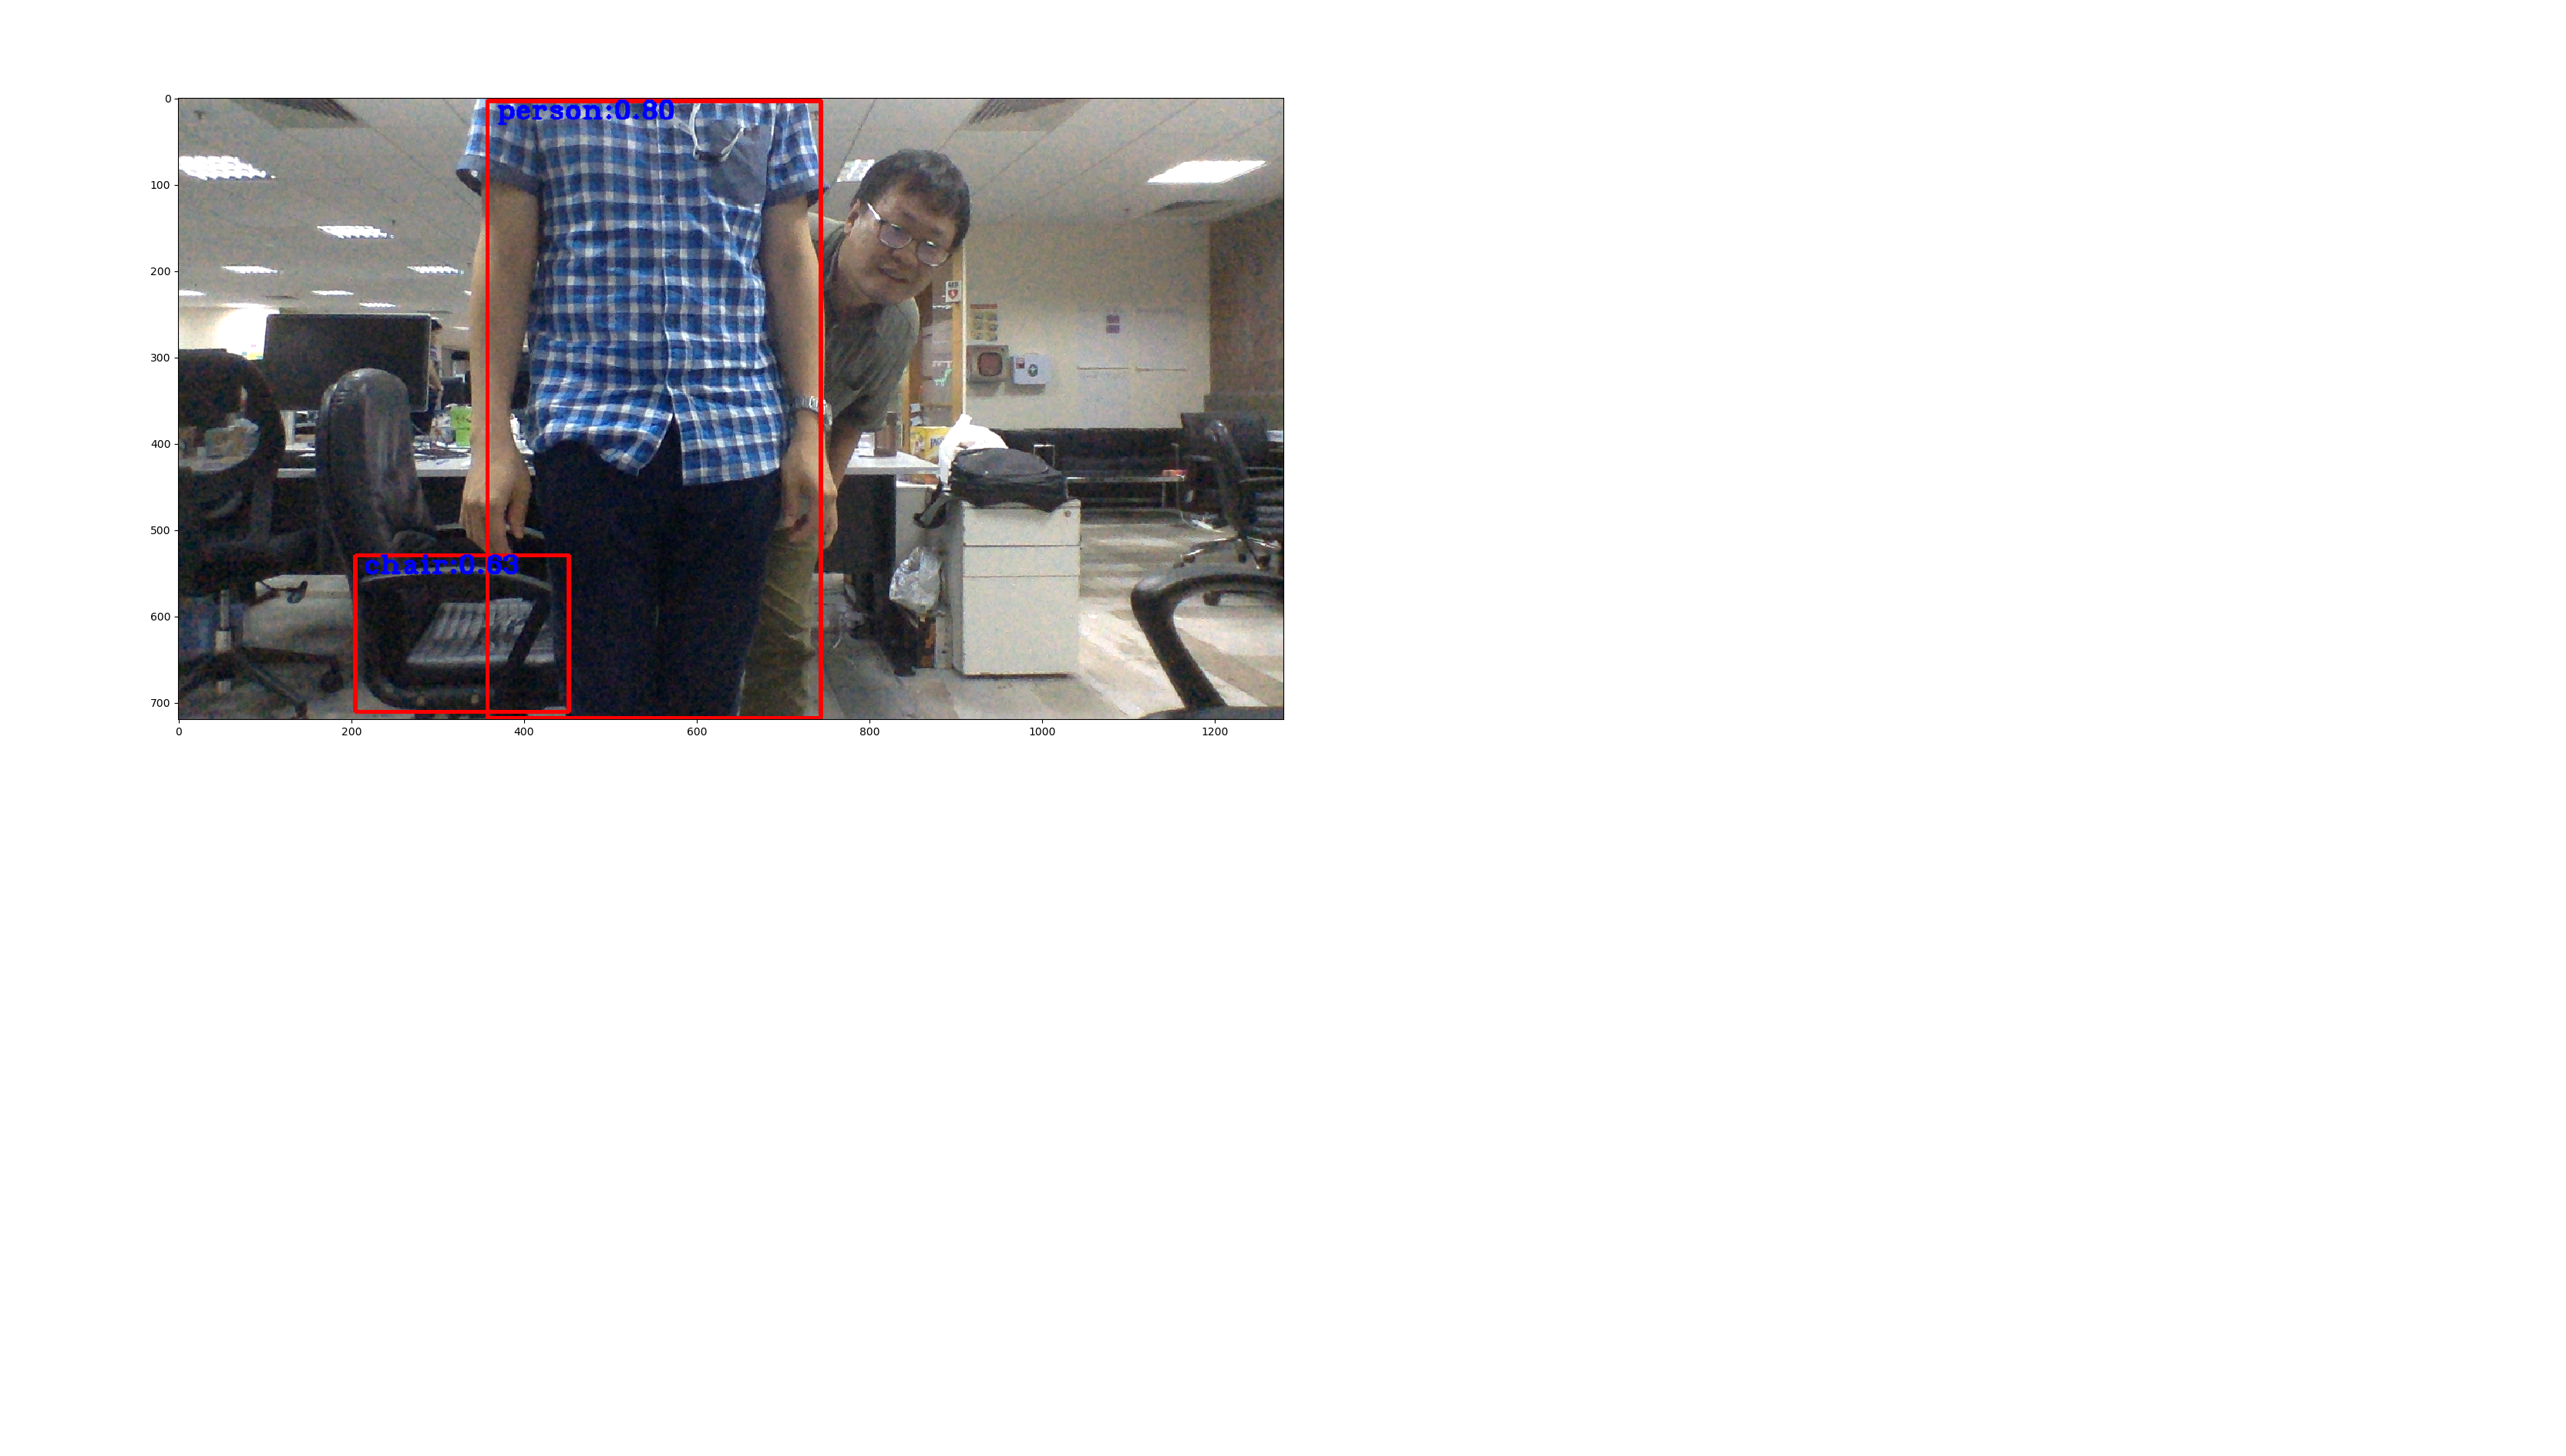

/Users/pmal252d/anaconda3/envs/py35/lib/python3.5/site-packages/matplotlib/backend_bases.py:2453: MatplotlibDeprecationWarning: Using default event loop until function specific to this GUI is implemented
  warnings.warn(str, mplDeprecation)


In [ ]:
vc = cv2.VideoCapture(0)

plt.ion()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

if vc.isOpened(): # try to get the first frame
    is_capturing, frame = vc.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)    # makes the blues image look real colored
    webcam_preview = plt.imshow(frame)    
else:
    is_capturing = False

while is_capturing:
    try:    # Lookout for a keyboardInterrupt to stop the script
        is_capturing, frame = vc.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)    # makes the blues image look real colored
        marked_frame = detect_objects(model_sess, id2label, frame, prob_thr=0.5)
        webcam_preview.set_data(marked_frame)
        plt.draw()
        try:    # Avoids a NotImplementedError caused by `plt.pause`
            plt.pause(0.05)
        except Exception:
            pass
    except KeyboardInterrupt:
        vc.release()